In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from collections import deque
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    df["S(t)"] = df["population"] - df["cumulative_confirmed"] - df["cumulative_deceased"] - df["recovered"]

    cols_to_smooth = ["S(t)","cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased", "new_confirmed"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31").drop(columns=["Unnamed: 0"], axis=1)

data.head(10)

def SEIRD_model(t, y, beta, gamma, mu, sigma, e, alpha, N):
    """SEIRD model differential equations."""
    S, E, I, R, D = y
    dSdt = -beta * S * (e * E + I) / N
    dEdt = beta * S * (e * E + I) / N - E / alpha
    dIdt = E / alpha - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def prepare_tensors(data, device):
    """Prepare tensors for training."""
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    return t, S, I, R, D

def scale_data(data, features):
    """Scale the data using MinMaxScaler."""
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data[features]), columns=features)
    return scaled_data, scaler  

# Define features and data split
features = ["S(t)", "active_cases", "recovered", "new_deceased"]

# Scale the data
scaled_data, scaler = scale_data(data, features)

# Prepare tensors
t_data, S_data, I_data, R_data, D_data = prepare_tensors(scaled_data, device)

class ModifiedTanh(nn.Module):
    def __init__(self, alpha, epsilon):
        super(ModifiedTanh, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon

    def forward(self, x):
        return 0.5 * torch.tanh(self.alpha * x) + self.epsilon

class ResBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.activation = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        identity = x.clone()
        out = self.fc(x)
        out = self.activation(out)
        if out.shape == identity.shape:
            out = out + identity
        return out

class StateNN(nn.Module):
    """Epidemiological network for predicting SEIRD model outputs."""
    def __init__(self, num_layers=4, hidden_neurons=20):
        super(StateNN, self).__init__()
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.append(ResBlock(hidden_neurons, hidden_neurons))
        layers.append(nn.Linear(hidden_neurons, 5))  # Adjust the output size to 5 (S, E, I, R, D)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        return self.net(t)

class ParamNN(nn.Module):
    """Neural network for predicting time-varying parameters."""
    def __init__(self, num_layers=4, hidden_neurons=20, alpha=1.0, epsilon=0.0):
        super(ParamNN, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon
        layers = [nn.Linear(1, hidden_neurons), ModifiedTanh(alpha, epsilon)]
        for _ in range(num_layers - 1):
            layers.append(ResBlock(hidden_neurons, hidden_neurons))
        layers.append(nn.Linear(hidden_neurons, 3))  # Adjust the output size to 3 (beta, gamma, mu)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        return self.net(t)

    def predict_parameters(self, t):
        params = self.net(t)
        # Ensure beta, gamma, and mu are in a valid range
        beta = torch.sigmoid(params[:, 0]) * 0.5  # range: [0, 0.5]
        gamma = torch.sigmoid(params[:, 1]) * 0.1  # range: [0, 0.1]
        mu = torch.sigmoid(params[:, 2]) * 0.1  # range: [0, 0.1]
        return beta, gamma, mu

def pinn_loss(t, data, state_nn, param_nn, N, sigma, alpha, epsilon):
    """Physics-Informed Neural Network loss function."""
    
    # Predicted states
    states_pred = state_nn(t)
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]
    
    # Compute gradients
    S_t = grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    E_t = grad(E_pred, t, grad_outputs=torch.ones_like(E_pred), create_graph=True)[0]   
    I_t = grad(I_pred, t, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    R_t = grad(R_pred, t, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = grad(D_pred, t, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # Predicted parameters
    beta_pred, gamma_pred, mu_pred = param_nn.predict_parameters(t)
    
    # SEIRD model residuals
    e = torch.tanh(param_nn.epsilon)
    alpha = 2 * torch.tanh(param_nn.alpha)
    
    dSdt, dEdt, dIdt, dRdt, dDdt = SEIRD_model(t, [S_pred, E_pred, I_pred, R_pred, D_pred], beta_pred, gamma_pred, mu_pred, sigma, e, alpha, N)
    
    # Compute data loss (MSE_u)
    S_data, I_data, R_data, D_data = data
    loss_data = torch.mean((S_pred - S_data)**2) + torch.mean((I_pred - I_data)**2) + torch.mean((R_pred - R_data)**2) + torch.mean((D_pred - D_data)**2)
    
    # Compute physics loss (MSE_f)
    loss_physics = torch.mean((S_t - dSdt)**2) + torch.mean((E_t - dEdt)**2) + torch.mean((I_t - dIdt)**2) + torch.mean((R_t - dRdt)**2) + torch.mean((D_t - dDdt)**2)
    
    # Total loss
    total_loss = loss_data + loss_physics
    
    return total_loss

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.loss_history = deque(maxlen=patience + 1)

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Hyperparameters
learning_rate = 1e-4
num_epochs = 50000
sigma = 1/5
N = data["population"].values[0]
alpha = 0.5
epsilon = 0.1

# Instantiate the neural networks with custom activation function
state_nn = StateNN(num_layers=6, hidden_neurons=32).to(device)
param_nn = ParamNN(num_layers=6, hidden_neurons=32, alpha=alpha, epsilon=epsilon).to(device)

# Optimizers
optimizer_state = optim.Adam(state_nn.parameters(), lr=learning_rate)
optimizer_param = optim.Adam(param_nn.parameters(), lr=learning_rate)

# Early stopping criteria
early_stopping = EarlyStopping(patience=20, verbose=False)

# Training loop
loss_history = []
for epoch in tqdm(range(num_epochs)):
    state_nn.train()
    param_nn.train()
    
    optimizer_state.zero_grad()
    optimizer_param.zero_grad()
    
    # Prepare time tensor
    t = torch.linspace(0, 1, steps=len(data)).view(-1, 1).to(device).requires_grad_(True)
    
    # Prepare data tensor
    S_data = torch.tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I_data = torch.tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R_data = torch.tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D_data = torch.tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    
    data_tensors = (S_data, I_data, R_data, D_data)
    
    # Compute loss
    loss = pinn_loss(t, data_tensors, state_nn, param_nn, N, sigma, alpha, epsilon)
    
    # Backpropagation
    loss.backward()
    
    optimizer_state.step()
    optimizer_param.step()
    
    loss_history.append(loss.item())
    
    if epoch % 500 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}")
    
    if early_stopping(loss.item()):
        print(f"Early stopping at epoch {epoch}. No improvement in loss for {early_stopping.patience} epochs.")
        break

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(np.log10(loss_history), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict and plot the results
state_nn.eval()
param_nn.eval()

with torch.no_grad():
    t = torch.linspace(0, 1, steps=len(t_data)).view(-1, 1).to(device)
    states_pred = state_nn(t).cpu().numpy()
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]

    # Inverse transform to get back to original scale for each variable separately
    I_pred = scaler.inverse_transform(np.concatenate([I_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]
    R_pred = scaler.inverse_transform(np.concatenate([R_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]
    D_pred = scaler.inverse_transform(np.concatenate([D_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]

# Plot infected predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], I_pred, label='Infected (Predicted)')
plt.plot(data["date"], data["active_cases"], label='Infected (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Infected Population')
plt.legend()
plt.show()

# Plot recovered predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], R_pred, label='Recovered (Predicted)')
plt.plot(data["date"], data["recovered"], label='Recovered (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Recovered Population')
plt.legend()
plt.show()

# Plot deceased predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], D_pred, label='Deceased (Predicted)')
plt.plot(data["date"], data["new_deceased"], label='Deceased (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Deceased Population')
plt.legend()
plt.show()


Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]


TypeError: tanh(): argument 'input' (position 1) must be Tensor, not float

Using device: cuda
PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7
Available GPUs: 2
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000


  0%|          | 1/50000 [00:00<1:44:34,  7.97it/s]

Epoch [1/50000], Loss: 44.756699


  1%|          | 502/50000 [00:56<1:32:40,  8.90it/s]

Epoch [501/50000], Loss: 0.384473


  2%|▏         | 1002/50000 [01:54<1:30:32,  9.02it/s]

Epoch [1001/50000], Loss: 0.314826


  3%|▎         | 1502/50000 [02:48<1:08:29, 11.80it/s]

Epoch [1501/50000], Loss: 0.305174


  4%|▍         | 2002/50000 [03:40<1:42:19,  7.82it/s]

Epoch [2001/50000], Loss: 0.303128


  5%|▌         | 2502/50000 [04:27<1:09:05, 11.46it/s]

Epoch [2501/50000], Loss: 0.302437


  6%|▌         | 3002/50000 [05:10<1:03:02, 12.43it/s]

Epoch [3001/50000], Loss: 0.302094


  7%|▋         | 3502/50000 [05:53<1:05:15, 11.87it/s]

Epoch [3501/50000], Loss: 0.301909


  8%|▊         | 4002/50000 [06:53<1:39:32,  7.70it/s]

Epoch [4001/50000], Loss: 0.301787


  9%|▉         | 4502/50000 [07:59<1:33:57,  8.07it/s]

Epoch [4501/50000], Loss: 0.301689


 10%|█         | 5002/50000 [09:01<1:34:31,  7.93it/s]

Epoch [5001/50000], Loss: 0.301607


 11%|█         | 5503/50000 [09:59<1:04:44, 11.45it/s]

Epoch [5501/50000], Loss: 0.301536


 12%|█▏        | 6003/50000 [10:42<1:04:14, 11.41it/s]

Epoch [6001/50000], Loss: 0.301472


 13%|█▎        | 6503/50000 [11:24<1:01:20, 11.82it/s]

Epoch [6501/50000], Loss: 0.301409


 14%|█▍        | 7002/50000 [12:09<1:32:28,  7.75it/s]

Epoch [7001/50000], Loss: 0.301339


 15%|█▌        | 7502/50000 [13:13<1:33:17,  7.59it/s]

Epoch [7501/50000], Loss: 0.301247


 16%|█▌        | 8002/50000 [14:16<1:30:45,  7.71it/s]

Epoch [8001/50000], Loss: 0.301106


 17%|█▋        | 8502/50000 [15:17<1:26:49,  7.97it/s]

Epoch [8501/50000], Loss: 0.300885


 18%|█▊        | 9002/50000 [16:19<1:28:13,  7.75it/s]

Epoch [9001/50000], Loss: 0.300630


 19%|█▉        | 9502/50000 [17:23<1:27:16,  7.73it/s]

Epoch [9501/50000], Loss: 0.300424


 20%|██        | 10002/50000 [18:25<1:22:44,  8.06it/s]

Epoch [10001/50000], Loss: 0.300252


 21%|██        | 10502/50000 [19:28<1:25:20,  7.71it/s]

Epoch [10501/50000], Loss: 0.300081


 22%|██▏       | 11002/50000 [20:32<1:21:00,  8.02it/s]

Epoch [11001/50000], Loss: 0.299925


 23%|██▎       | 11502/50000 [21:32<1:23:19,  7.70it/s]

Epoch [11501/50000], Loss: 0.299875


 24%|██▍       | 12002/50000 [22:35<1:22:28,  7.68it/s]

Epoch [12001/50000], Loss: 0.299825


 25%|██▌       | 12502/50000 [23:33<1:06:34,  9.39it/s]

Epoch [12501/50000], Loss: 0.299808


 26%|██▌       | 13002/50000 [24:30<1:07:50,  9.09it/s]

Epoch [13001/50000], Loss: 0.299798


 27%|██▋       | 13502/50000 [25:25<1:07:35,  9.00it/s]

Epoch [13501/50000], Loss: 0.299904


 28%|██▊       | 14002/50000 [26:23<1:06:06,  9.08it/s]

Epoch [14001/50000], Loss: 0.299791


 29%|██▉       | 14502/50000 [27:17<51:41, 11.44it/s]  

Epoch [14501/50000], Loss: 0.299795


 30%|███       | 15002/50000 [28:09<58:45,  9.93it/s]  

Epoch [15001/50000], Loss: 0.299782


 31%|███       | 15502/50000 [29:02<58:08,  9.89it/s]  

Epoch [15501/50000], Loss: 0.299781


 32%|███▏      | 16003/50000 [29:47<47:37, 11.90it/s]

Epoch [16001/50000], Loss: 0.299782


 33%|███▎      | 16503/50000 [30:30<48:32, 11.50it/s]

Epoch [16501/50000], Loss: 0.299785


 34%|███▍      | 17002/50000 [31:24<1:07:56,  8.09it/s]

Epoch [17001/50000], Loss: 0.299787


 35%|███▌      | 17502/50000 [32:27<1:10:47,  7.65it/s]

Epoch [17501/50000], Loss: 0.299777


 36%|███▌      | 18002/50000 [33:28<1:08:55,  7.74it/s]

Epoch [18001/50000], Loss: 0.299777


 37%|███▋      | 18502/50000 [34:26<57:28,  9.13it/s]  

Epoch [18501/50000], Loss: 0.299777


 38%|███▊      | 19002/50000 [35:27<1:00:16,  8.57it/s]

Epoch [19001/50000], Loss: 0.299777


 39%|███▉      | 19502/50000 [36:28<55:22,  9.18it/s]  

Epoch [19501/50000], Loss: 0.299776


 40%|████      | 20002/50000 [37:28<54:30,  9.17it/s]  

Epoch [20001/50000], Loss: 0.299776


 41%|████      | 20502/50000 [38:24<1:03:05,  7.79it/s]

Epoch [20501/50000], Loss: 0.299776


 42%|████▏     | 21002/50000 [39:20<52:06,  9.28it/s]  

Epoch [21001/50000], Loss: 0.299878


 43%|████▎     | 21502/50000 [40:15<56:49,  8.36it/s]  

Epoch [21501/50000], Loss: 0.299779


 44%|████▍     | 22002/50000 [41:12<1:01:34,  7.58it/s]

Epoch [22001/50000], Loss: 0.299777


 45%|████▌     | 22502/50000 [42:16<50:34,  9.06it/s]  

Epoch [22501/50000], Loss: 0.299776


 46%|████▌     | 23002/50000 [43:15<48:25,  9.29it/s]

Epoch [23001/50000], Loss: 0.299896


 47%|████▋     | 23502/50000 [44:12<47:48,  9.24it/s]

Epoch [23501/50000], Loss: 0.299975


 48%|████▊     | 24002/50000 [45:11<46:45,  9.27it/s]

Epoch [24001/50000], Loss: 0.299775


 49%|████▉     | 24502/50000 [46:13<55:51,  7.61it/s]

Epoch [24501/50000], Loss: 0.299775


 50%|█████     | 25002/50000 [47:21<56:34,  7.36it/s]  

Epoch [25001/50000], Loss: 0.299774


 51%|█████     | 25502/50000 [48:21<52:51,  7.73it/s]

Epoch [25501/50000], Loss: 0.299776


 52%|█████▏    | 26002/50000 [49:19<44:04,  9.08it/s]

Epoch [26001/50000], Loss: 0.299775


 53%|█████▎    | 26502/50000 [50:16<49:11,  7.96it/s]

Epoch [26501/50000], Loss: 0.299779


 54%|█████▍    | 27002/50000 [51:14<50:35,  7.58it/s]

Epoch [27001/50000], Loss: 0.299774


 55%|█████▌    | 27502/50000 [52:18<50:00,  7.50it/s]

Epoch [27501/50000], Loss: 0.299775


 56%|█████▌    | 28002/50000 [53:23<38:34,  9.50it/s]

Epoch [28001/50000], Loss: 0.299774


 57%|█████▋    | 28502/50000 [54:27<36:47,  9.74it/s]

Epoch [28501/50000], Loss: 0.299775


 58%|█████▊    | 29002/50000 [55:22<36:22,  9.62it/s]

Epoch [29001/50000], Loss: 0.299774


 59%|█████▉    | 29502/50000 [56:27<46:03,  7.42it/s]

Epoch [29501/50000], Loss: 0.299775


 60%|██████    | 30002/50000 [57:33<44:07,  7.55it/s]

Epoch [30001/50000], Loss: 0.299774


 61%|██████    | 30502/50000 [58:39<43:07,  7.54it/s]

Epoch [30501/50000], Loss: 0.299774


 62%|██████▏   | 31002/50000 [59:43<36:56,  8.57it/s]

Epoch [31001/50000], Loss: 0.299774


 63%|██████▎   | 31502/50000 [1:00:42<36:06,  8.54it/s]

Epoch [31501/50000], Loss: 0.299777


 64%|██████▍   | 32002/50000 [1:01:44<38:18,  7.83it/s]

Epoch [32001/50000], Loss: 0.299774


 65%|██████▌   | 32502/50000 [1:02:39<30:54,  9.43it/s]

Epoch [32501/50000], Loss: 0.299774


 66%|██████▌   | 33002/50000 [1:03:33<30:01,  9.43it/s]

Epoch [33001/50000], Loss: 0.299775


 67%|██████▋   | 33502/50000 [1:04:34<35:06,  7.83it/s]

Epoch [33501/50000], Loss: 0.299774


 68%|██████▊   | 34002/50000 [1:05:36<33:40,  7.92it/s]

Epoch [34001/50000], Loss: 0.299774


 69%|██████▉   | 34502/50000 [1:06:39<27:31,  9.38it/s]

Epoch [34501/50000], Loss: 0.299785


 70%|███████   | 35002/50000 [1:07:37<31:45,  7.87it/s]

Epoch [35001/50000], Loss: 0.299774


 71%|███████   | 35502/50000 [1:08:36<26:12,  9.22it/s]

Epoch [35501/50000], Loss: 0.299774


 72%|███████▏  | 36002/50000 [1:09:33<26:29,  8.81it/s]

Epoch [36001/50000], Loss: 0.299780


 73%|███████▎  | 36502/50000 [1:10:31<24:08,  9.32it/s]

Epoch [36501/50000], Loss: 0.299807


 74%|███████▍  | 37002/50000 [1:11:28<27:09,  7.98it/s]

Epoch [37001/50000], Loss: 0.299818


 75%|███████▌  | 37502/50000 [1:12:28<27:13,  7.65it/s]

Epoch [37501/50000], Loss: 0.299776


 76%|███████▌  | 38003/50000 [1:13:18<16:52, 11.85it/s]

Epoch [38001/50000], Loss: 0.299774


 77%|███████▋  | 38503/50000 [1:14:02<16:44, 11.44it/s]

Epoch [38501/50000], Loss: 0.299774


 78%|███████▊  | 39003/50000 [1:14:45<16:01, 11.44it/s]

Epoch [39001/50000], Loss: 0.299775


 79%|███████▉  | 39503/50000 [1:15:29<16:15, 10.76it/s]

Epoch [39501/50000], Loss: 0.299774


 80%|████████  | 40003/50000 [1:16:13<14:51, 11.22it/s]

Epoch [40001/50000], Loss: 0.299845


 81%|████████  | 40503/50000 [1:16:48<08:05, 19.54it/s]

Epoch [40501/50000], Loss: 0.299779


 82%|████████▏ | 41003/50000 [1:17:13<07:41, 19.48it/s]

Epoch [41001/50000], Loss: 0.299773


 83%|████████▎ | 41503/50000 [1:17:48<12:45, 11.09it/s]

Epoch [41501/50000], Loss: 0.299776


 84%|████████▍ | 42003/50000 [1:18:33<12:59, 10.26it/s]

Epoch [42001/50000], Loss: 0.299774


 85%|████████▌ | 42503/50000 [1:19:17<10:28, 11.94it/s]

Epoch [42501/50000], Loss: 0.299782


 86%|████████▌ | 43003/50000 [1:19:55<09:35, 12.15it/s]

Epoch [43001/50000], Loss: 0.299774


 87%|████████▋ | 43503/50000 [1:20:38<09:20, 11.59it/s]

Epoch [43501/50000], Loss: 0.299773


 88%|████████▊ | 44003/50000 [1:21:22<08:42, 11.48it/s]

Epoch [44001/50000], Loss: 0.299785


 89%|████████▉ | 44503/50000 [1:22:06<08:10, 11.21it/s]

Epoch [44501/50000], Loss: 0.299774


 90%|█████████ | 45003/50000 [1:22:51<07:01, 11.85it/s]

Epoch [45001/50000], Loss: 0.299777


 91%|█████████ | 45503/50000 [1:23:34<06:36, 11.35it/s]

Epoch [45501/50000], Loss: 0.299773


 92%|█████████▏| 46003/50000 [1:24:14<03:24, 19.59it/s]

Epoch [46001/50000], Loss: 0.299774


 93%|█████████▎| 46503/50000 [1:24:52<05:05, 11.45it/s]

Epoch [46501/50000], Loss: 0.299778


 94%|█████████▍| 47003/50000 [1:25:36<04:26, 11.25it/s]

Epoch [47001/50000], Loss: 0.299774


 95%|█████████▌| 47503/50000 [1:26:20<03:38, 11.40it/s]

Epoch [47501/50000], Loss: 0.299773


 96%|█████████▌| 48003/50000 [1:27:03<02:42, 12.25it/s]

Epoch [48001/50000], Loss: 0.299773


 97%|█████████▋| 48503/50000 [1:27:46<02:06, 11.86it/s]

Epoch [48501/50000], Loss: 0.299792


 98%|█████████▊| 49003/50000 [1:28:28<01:21, 12.22it/s]

Epoch [49001/50000], Loss: 0.299777


 99%|█████████▉| 49503/50000 [1:29:10<00:40, 12.28it/s]

Epoch [49501/50000], Loss: 0.299773


100%|██████████| 50000/50000 [1:29:53<00:00,  9.27it/s]


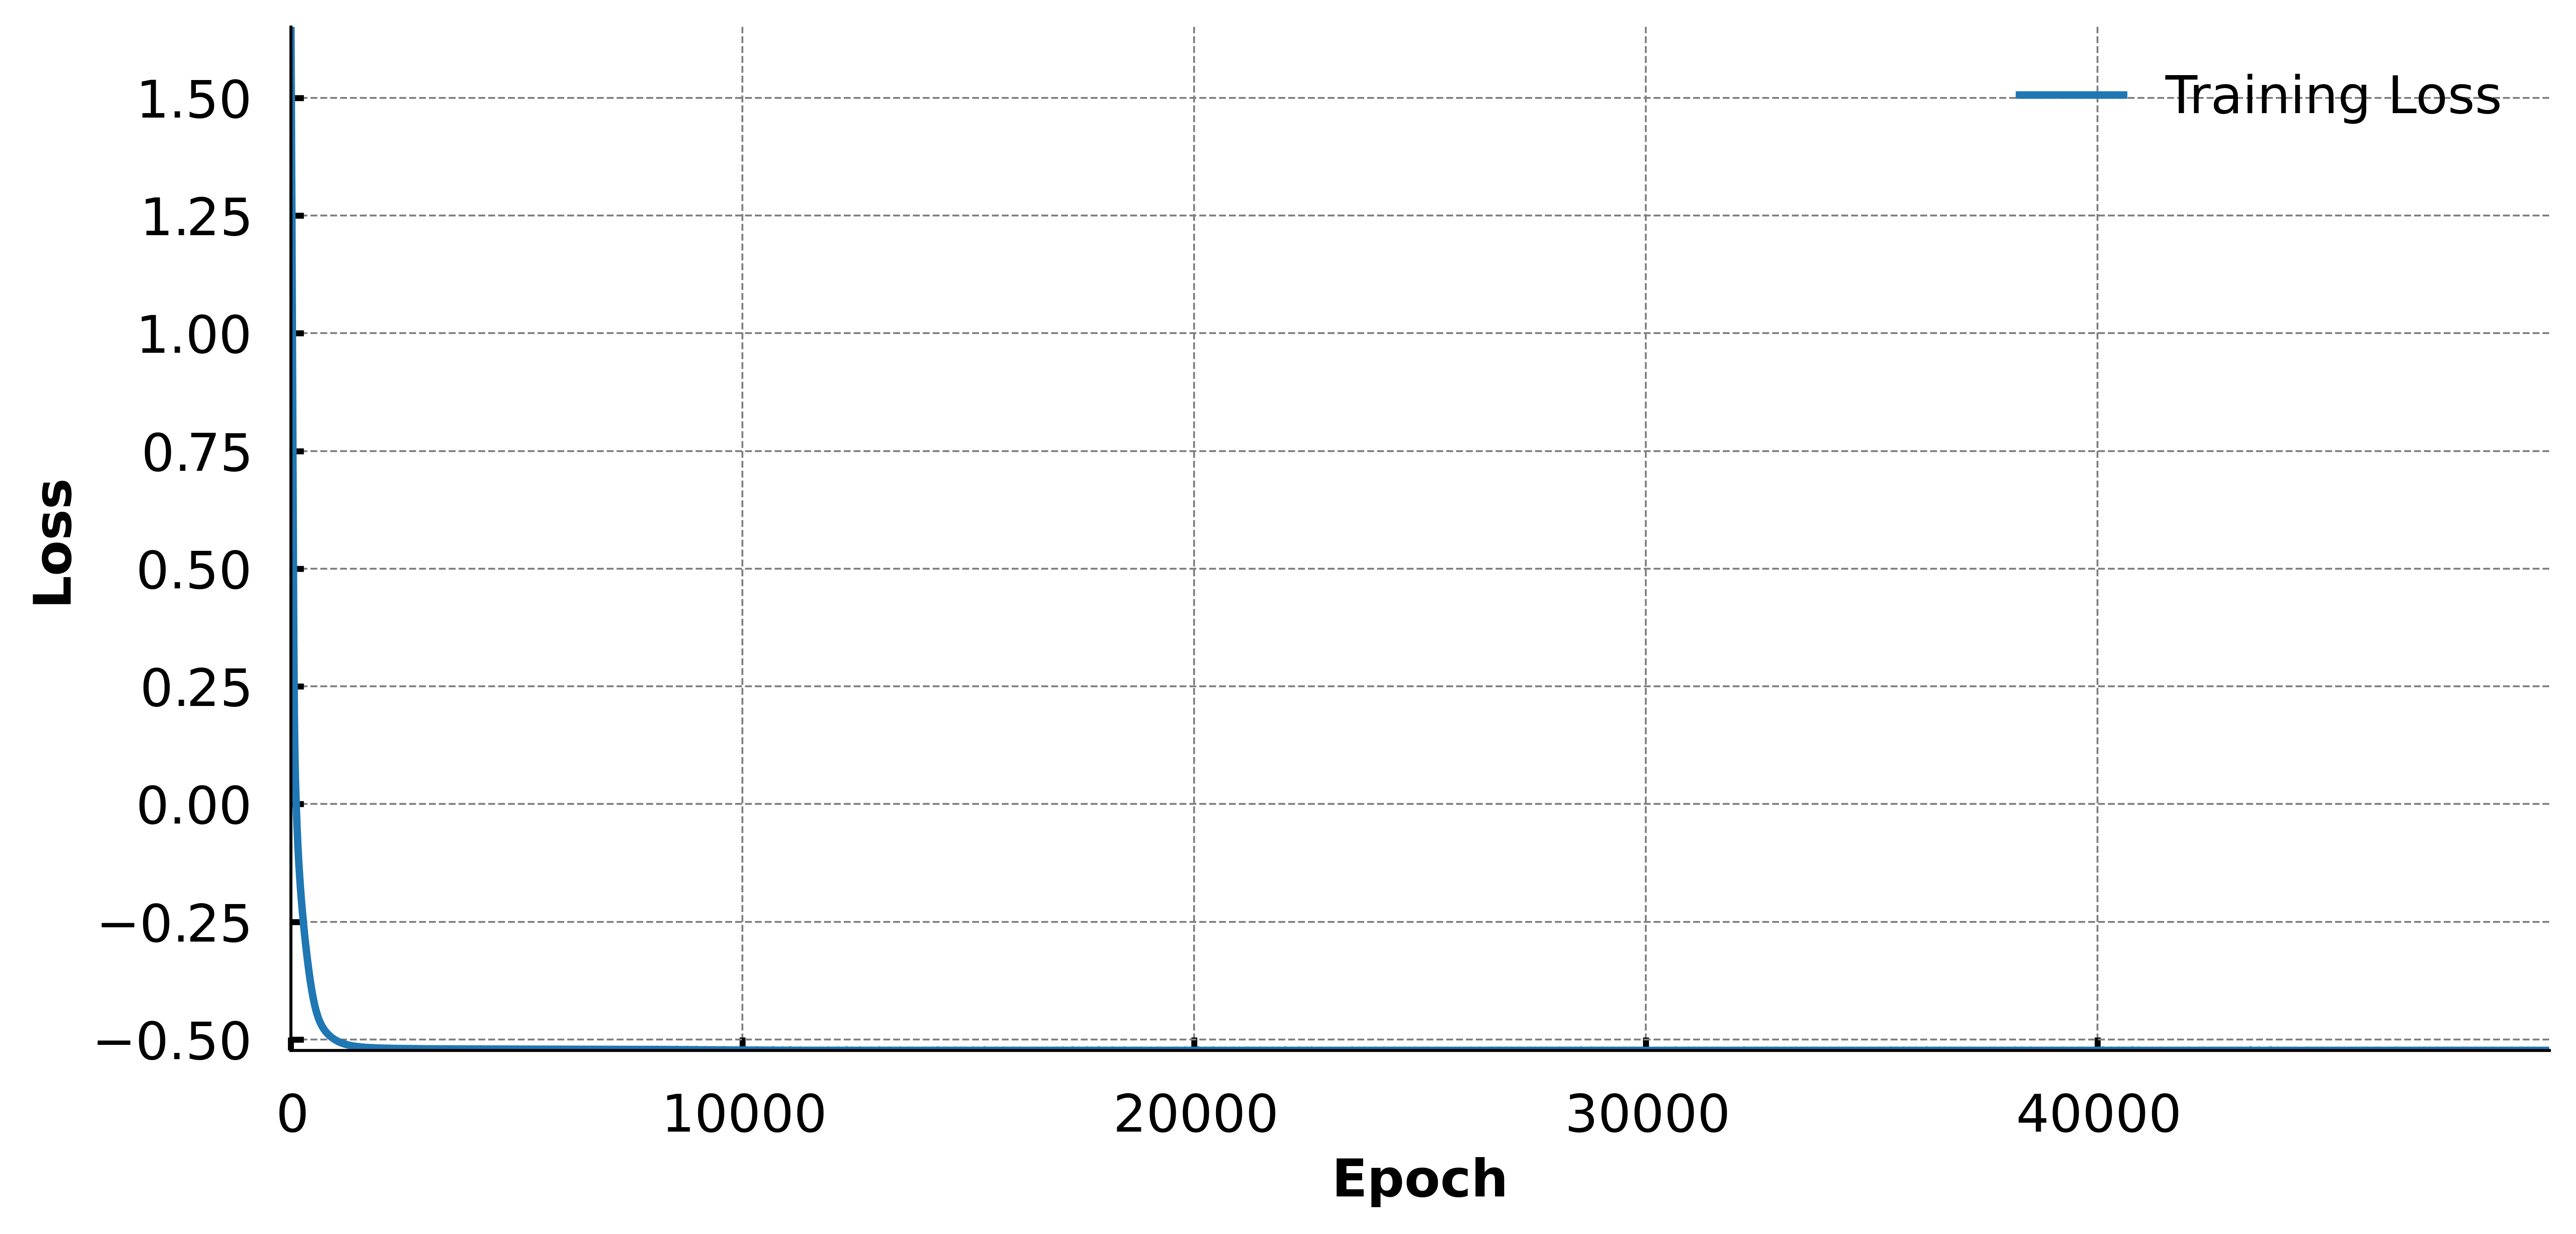

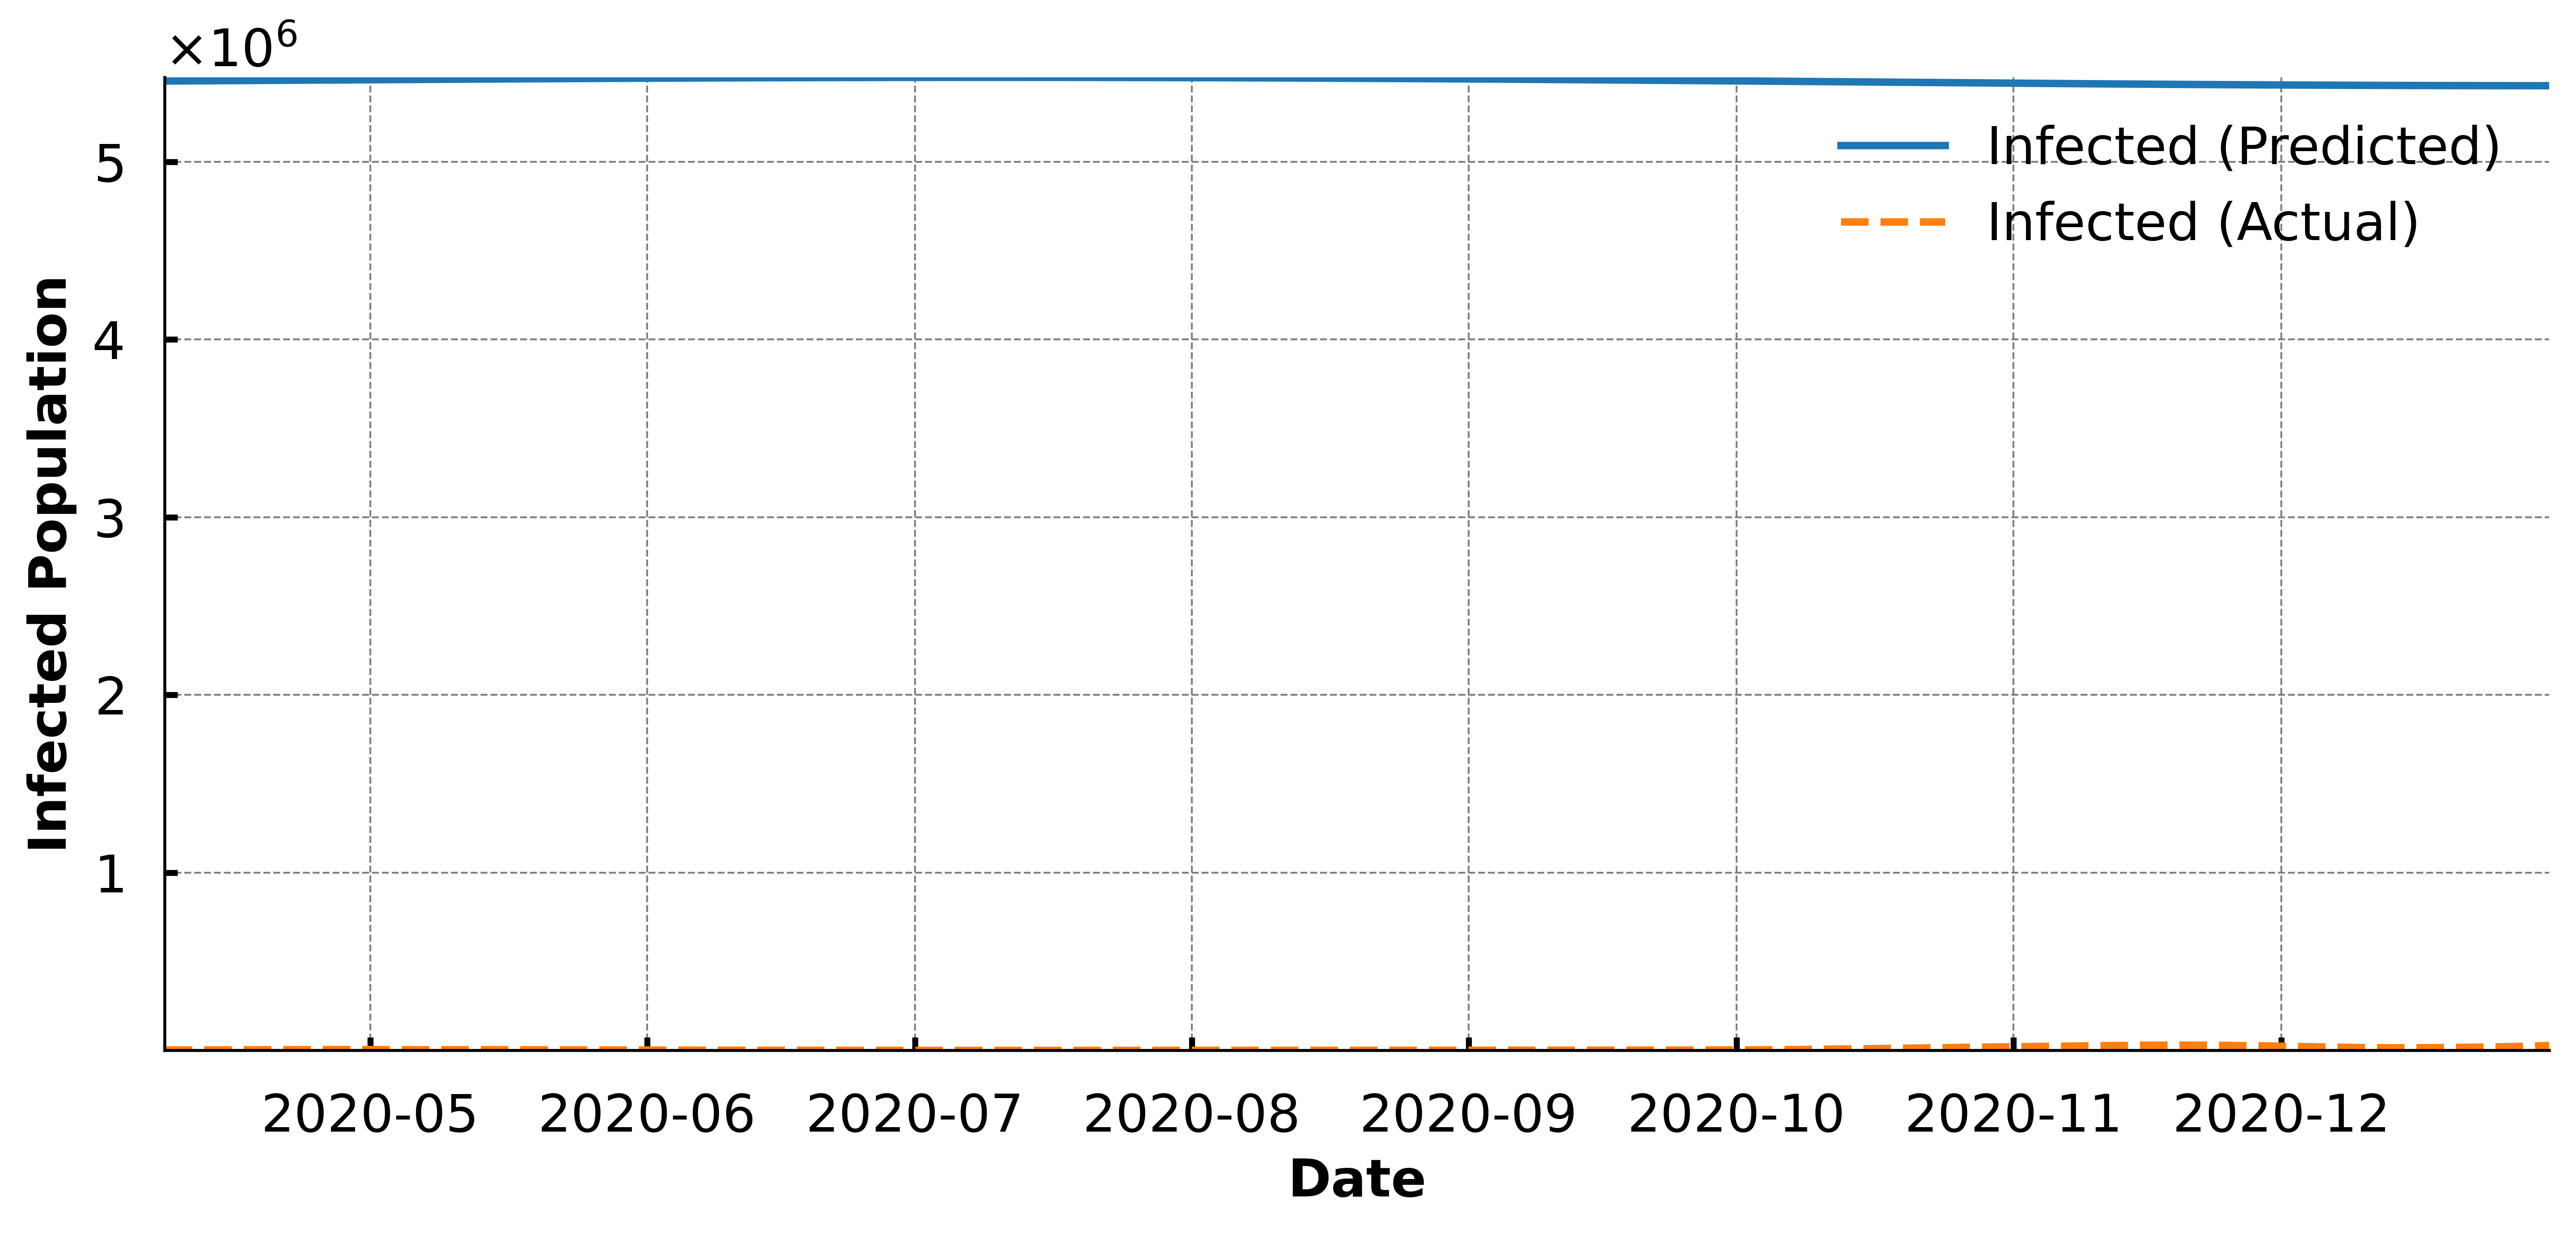

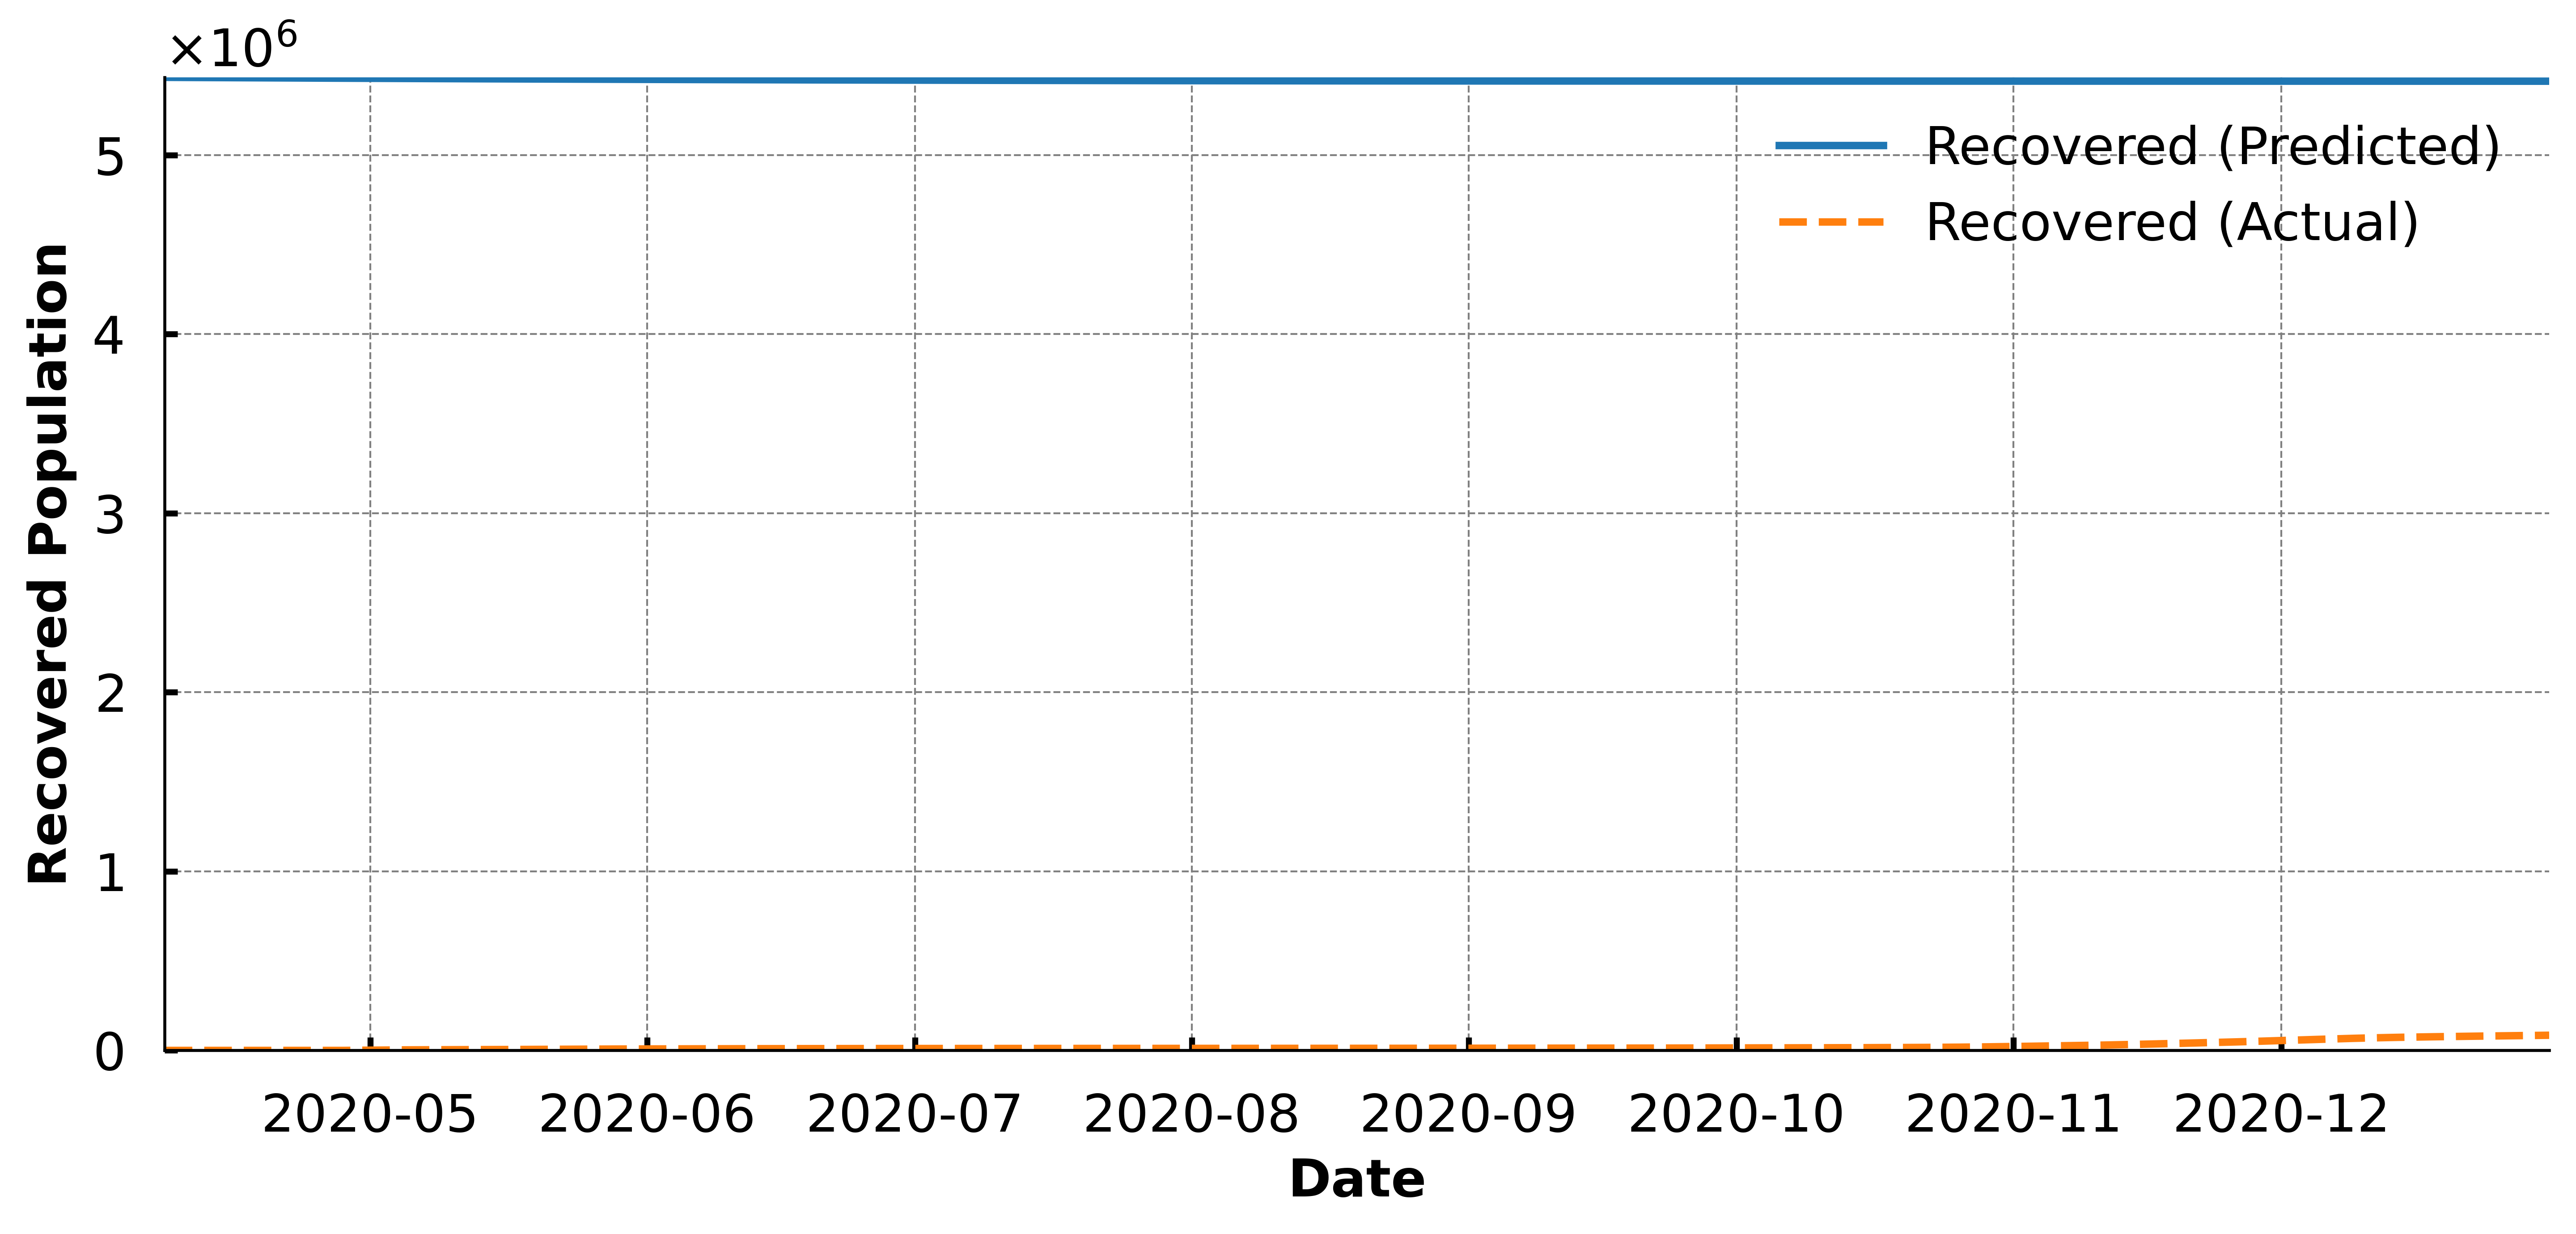

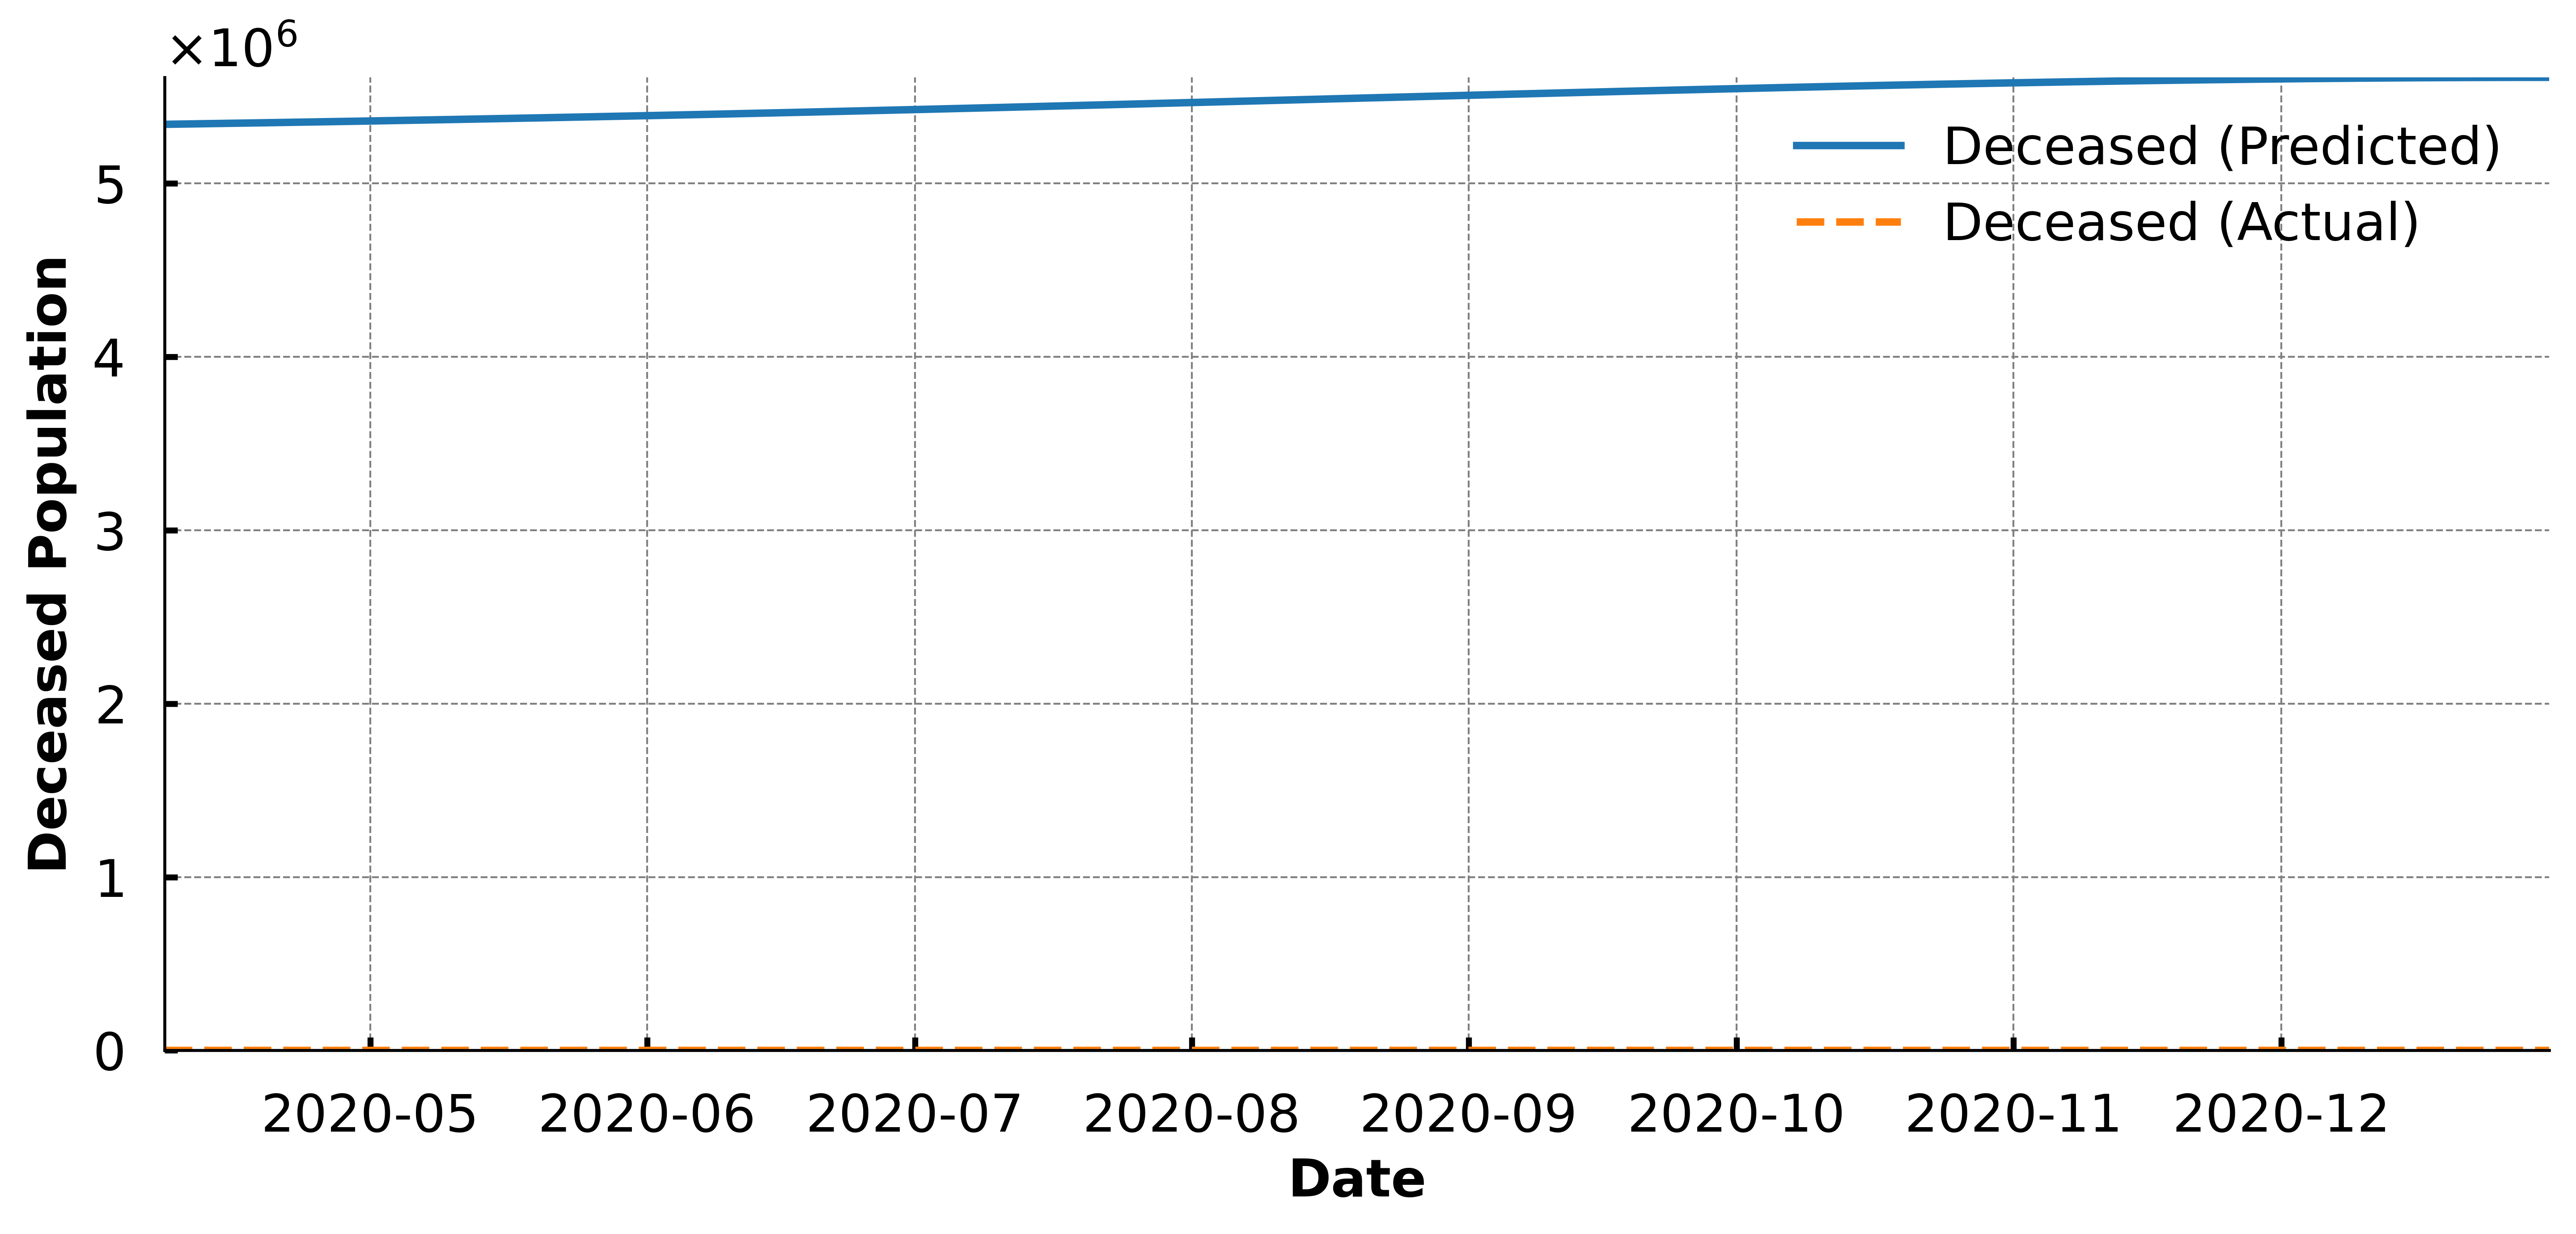

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from collections import deque
from sklearn.preprocessing import MinMaxScaler
from tqdm.noteboook import tqdm

# Set matplotlib style and parameters
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
    "font.size": 20,
    "figure.figsize": [10, 5],
    "figure.facecolor": "white",
    "figure.autolayout": True,
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.facecolor": "white",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.formatter.limits": (0, 5),
    "axes.formatter.use_mathtext": True,
    "axes.formatter.useoffset": False,
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "legend.loc": "best",
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "xtick.labelsize": 14,
    "xtick.direction": "in",
    "xtick.top": False,
    "ytick.labelsize": 14,
    "ytick.direction": "in",
    "ytick.right": False,
    "grid.color": "grey",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "errorbar.capsize": 4,
    "figure.subplot.wspace": 0.4,
    "figure.subplot.hspace": 0.4,
    "image.cmap": "viridis",
})

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def check_pytorch():
    """Check PyTorch and CUDA setup."""
    print(f"PyTorch version: {torch.__version__}")
    cuda_available = torch.cuda.is_available()
    print(f"CUDA available: {cuda_available}")
    if cuda_available:
        print(f"CUDA version: {torch.version.cuda}")
        gpu_count = torch.cuda.device_count()
        print(f"Available GPUs: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA not available. PyTorch will run on CPU.")

check_pytorch()

def load_and_preprocess_data(filepath, areaname, recovery_period=16, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31"):
    """Load and preprocess the data from a CSV file."""
    df = pd.read_csv(filepath)
    df = df[df["areaName"] == areaname].reset_index(drop=True)
    df = df[::-1].reset_index(drop=True)  # Reverse dataset if needed

    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"] >= pd.to_datetime(start_date)) & (df["date"] <= pd.to_datetime(end_date))]

    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df["cumulative_deceased"].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)
    df["active_cases"] = df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    df["S(t)"] = df["population"] - df["cumulative_confirmed"] - df["cumulative_deceased"] - df["recovered"]

    cols_to_smooth = ["S(t)", "cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds", "recovered", "active_cases", "new_deceased", "new_confirmed"]
    for col in cols_to_smooth:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    return df

# Load and preprocess the data
data = load_and_preprocess_data("../../data/hos_data/merged_data.csv", areaname="South West", recovery_period=21, rolling_window=7, start_date="2020-04-01", end_date="2020-12-31").drop(columns=["Unnamed: 0"], axis=1)

data.head(10)

def SEIRD_model(t, y, beta, gamma, mu, sigma, e, alpha, N):
    """SEIRD model differential equations."""
    S, E, I, R, D = y
    dSdt = -beta * S * (e * E + I) / N
    dEdt = beta * S * (e * E + I) / N - E / alpha
    dIdt = E / alpha - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def prepare_tensors(data, device):
    """Prepare tensors for training."""
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    return t, S, I, R, D

def scale_data(data, features):
    """Scale the data using MinMaxScaler."""
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data[features]), columns=features)
    return scaled_data, scaler  

# Define features and data split
features = ["S(t)", "active_cases", "recovered", "new_deceased"]

# Scale the data
scaled_data, scaler = scale_data(data, features)

# Prepare tensors
t_data, S_data, I_data, R_data, D_data = prepare_tensors(scaled_data, device)

class ModifiedTanh(nn.Module):
    def __init__(self, alpha, epsilon):
        super(ModifiedTanh, self).__init__()
        self.alpha = alpha
        self.epsilon = epsilon

    def forward(self, x):
        return 0.5 * torch.tanh(self.alpha * x) + self.epsilon

class ResBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.activation = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        identity = x.clone()
        out = self.fc(x)
        out = self.activation(out)
        if out.shape == identity.shape:
            out = out + identity
        return out

class StateNN(nn.Module):
    """Epidemiological network for predicting SEIRD model outputs."""
    def __init__(self, num_layers=4, hidden_neurons=20):
        super(StateNN, self).__init__()
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.append(ResBlock(hidden_neurons, hidden_neurons))
        layers.append(nn.Linear(hidden_neurons, 5))  # Adjust the output size to 5 (S, E, I, R, D)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        return self.net(t)

class ParamNN(nn.Module):
    """Neural network for predicting time-varying parameters."""
    def __init__(self, num_layers=4, hidden_neurons=20):
        super(ParamNN, self).__init__()
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.append(ResBlock(hidden_neurons, hidden_neurons))
        layers.append(nn.Linear(hidden_neurons, 3))  # Adjust the output size to 3 (beta, gamma, mu)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        params = self.net(t)
        # Ensure beta, gamma, and mu are in a valid range
        beta = torch.sigmoid(params[:, 0]) * 0.5  # range: [0, 0.5]
        gamma = torch.sigmoid(params[:, 1]) * 0.1  # range: [0, 0.1]
        mu = torch.sigmoid(params[:, 2]) * 0.1  # range: [0, 0.1]
        return beta, gamma, mu

def pinn_loss(t, data, state_nn, param_nn, N, sigma, alpha, epsilon):
    """Physics-Informed Neural Network loss function."""
    
    # Predicted states
    states_pred = state_nn(t)
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]
    
    # Compute gradients
    S_t = grad(S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    E_t = grad(E_pred, t, grad_outputs=torch.ones_like(E_pred), create_graph=True)[0]   
    I_t = grad(I_pred, t, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    R_t = grad(R_pred, t, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = grad(D_pred, t, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # Predicted parameters
    beta_pred, gamma_pred, mu_pred = param_nn(t)
    
    # SEIRD model residuals
    e_tensor = torch.tensor(epsilon, dtype=torch.float32, device=device, requires_grad=True)
    alpha_tensor = torch.tensor(alpha, dtype=torch.float32, device=device, requires_grad=True)
    
    e = torch.tanh(e_tensor)
    alpha = 2 * torch.tanh(alpha_tensor)
    
    dSdt, dEdt, dIdt, dRdt, dDdt = SEIRD_model(t, [S_pred, E_pred, I_pred, R_pred, D_pred], beta_pred, gamma_pred, mu_pred, sigma, e, alpha, N)
    
    # Compute data loss (MSE_u)
    S_data, I_data, R_data, D_data = data
    loss_data = torch.mean((S_pred - S_data)**2) + torch.mean((I_pred - I_data)**2) + torch.mean((R_pred - R_data)**2) + torch.mean((D_pred - D_data)**2)
    
    # Compute physics loss (MSE_f)
    loss_physics = torch.mean((S_t - dSdt)**2) + torch.mean((E_t - dEdt)**2) + torch.mean((I_t - dIdt)**2) + torch.mean((R_t - dRdt)**2) + torch.mean((D_t - dDdt)**2)
    
    # initial condition loss
    loss_initial = torch.mean((S_pred[0] - S_data[0])**2) + torch.mean((I_pred[0] - I_data[0])**2) + torch.mean((R_pred[0] - R_data[0])**2) + torch.mean((D_pred[0] - D_data[0])**2)
    
    # Total loss    
    total_loss = loss_data + loss_physics + loss_initial
    
    return total_loss

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve."""
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.loss_history = deque(maxlen=patience + 1)

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Hyperparameters
learning_rate = 1e-4
num_epochs = 50000
sigma = 1/5
N = data["population"].values[0]
alpha = 0.5
epsilon = 0.1

# Instantiate the neural networks with custom activation function
state_nn = StateNN(num_layers=6, hidden_neurons=32).to(device)
param_nn = ParamNN(num_layers=6, hidden_neurons=32).to(device)

# Optimizers
optimizer_state = optim.Adam(state_nn.parameters(), lr=learning_rate)
optimizer_param = optim.Adam(param_nn.parameters(), lr=learning_rate)

# Early stopping criteria
early_stopping = EarlyStopping(patience=20, verbose=False)

# Training loop
loss_history = []
for epoch in tqdm(range(num_epochs)):
    state_nn.train()
    param_nn.train()
    
    optimizer_state.zero_grad()
    optimizer_param.zero_grad()
    
    # Prepare time tensor
    # Prepare time tensor
    t = t_data
    
    data_tensors = (S_data, I_data, R_data, D_data)
    
    # Compute loss
    loss = pinn_loss(t, data_tensors, state_nn, param_nn, N, sigma, alpha, epsilon)
    
    # Backpropagation
    loss.backward()
    
    optimizer_state.step()
    optimizer_param.step()
    
    loss_history.append(loss.item())
    
    if epoch % 500 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}")
    
    if early_stopping(loss.item()):
        print(f"Early stopping at epoch {epoch}. No improvement in loss for {early_stopping.patience} epochs.")
        break

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(np.log10(loss_history), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict and plot the results
state_nn.eval()
param_nn.eval()

with torch.no_grad():
    t = torch.linspace(0, 1, steps=len(t_data)).view(-1, 1).to(device)
    states_pred = state_nn(t).cpu().numpy()
    S_pred, E_pred, I_pred, R_pred, D_pred = states_pred[:, 0], states_pred[:, 1], states_pred[:, 2], states_pred[:, 3], states_pred[:, 4]

    # Inverse transform to get back to original scale for each variable separately
    I_pred = scaler.inverse_transform(np.concatenate([I_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]
    R_pred = scaler.inverse_transform(np.concatenate([R_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]
    D_pred = scaler.inverse_transform(np.concatenate([D_pred.reshape(-1, 1)] * len(features), axis=1))[:, 0]

# Plot infected predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], I_pred, label='Infected (Predicted)')
plt.plot(data["date"], data["active_cases"], label='Infected (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Infected Population')
plt.legend()
plt.show()

# Plot recovered predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], R_pred, label='Recovered (Predicted)')
plt.plot(data["date"], data["recovered"], label='Recovered (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Recovered Population')
plt.legend()
plt.show()

# Plot deceased predicted vs real data
plt.figure(figsize=(10, 5))
plt.plot(data["date"], D_pred, label='Deceased (Predicted)')
plt.plot(data["date"], data["new_deceased"], label='Deceased (Actual)', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Deceased Population')
plt.legend()
plt.show()
